## Simple jupyter notebook for plotting 2D histogram of GAIA data

### Import necessary modules

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import pyspark.sql.functions as F
from pyspark.sql.types import *

In [2]:
def histogram2d(df, cond1, cond2, numbins1, numbins2, min1=None, max1=None, min2=None, max2=None):
     """
     Uses `cond1` and `cond2` colunm expressions to obtain data for 2D histogram calculation. The data on
     x axis will be binned into `numbins1` bins. The data on y axis will be binned into `numbins2` bins.
     If `min1`, `max1`, `min2` or `max2` are not spacified, they will be calculated using an additional pass
     through the data.
     The method returns x, y and z 2-D numpy arrays (see numpy.mgrid) which can be used as an input to
     `matplotlib.pcolormesh`.

     :param cond1: Column expression determining the data on x axis.
     :param cond2: Column expression determining the data on y axis.
     :param numbins1: Number of bins for x axis.
     :param numbins2: Number of bins for y axis.
     :param min1: Optional minimum value for x axis data.
     :param max1: Optional maximum value for x axis data.
     :param min2: Optional minimum value for y axis data.
     :param max2: Optional maximum value for y axis data.
     :return: x, y, z 2-D numpy "meshgrid" arrays (see numpy.mgrid)
     """
     colname1 = "axs_hist_col1"
     colname2 = "axs_hist_col2"
     res = df.select(cond1.alias(colname1), cond2.alias(colname2))

     if min1 is None or max1 is None or min2 is None or max2 is None:
         mm = res.select(F.min(res[colname1]).alias("min1"), F.max(res[colname1]).alias("max1"),
                         F.min(res[colname2]).alias("min2"), F.max(res[colname2]).alias("max2")).\
             collect()
         (min1, max1, min2, max2) = (mm[0]["min1"], mm[0]["max1"], mm[0]["min2"], mm[0]["max2"])
  
     rng1 = float(max1 - min1)
     rng2 = float(max2 - min2)
     step1 = rng1 / numbins1
     step2 = rng2 / numbins2
    
     hist2d = res.withColumn("bin1", ((res[colname1]-min1)/step1).cast("int")*step1+min1) \
         .withColumn("bin2", ((res[colname2]-min2)/step2).cast("int")*step2+min2).\
         groupBy("bin1", "bin2").count()
   
     hist2data = hist2d.orderBy(hist2d.bin1, hist2d.bin2).collect()
     
     bin1 = list(map(lambda row: row.bin1, hist2data))
     bin2 = list(map(lambda row: row.bin2, hist2data))
     vals = list(map(lambda row: row["count"], hist2data))
    
     x, y = np.mgrid[slice(min1, max1 + step1, step1),
                     slice(min2, max2 + step2, step2)]
     z = np.zeros(x.shape)
     
     for b1, b2, v in zip(bin1, bin2, vals):
         z[round((b1-min1)/step1)][round((b2-min2)/step2)] = v
     return x, y, z

### Provision Spark Cluster

In [3]:
# provision with LARGE instance
import camber
spark = camber.spark.connect(worker_size = 'LARGE')

Output()

In [4]:
# Read in unsorted spark source catalog and set schema
schema = StructType([StructField('solution_id', LongType(), True),
                     StructField('designation', StringType(), True), 
                     StructField('source_id', LongType(), True), 
                     StructField('random_index', IntegerType(), True), 
                     StructField('ref_epoch', DoubleType(), True), 
                     StructField('ra', DoubleType(), True), StructField('ra_error', DoubleType(), True), 
                     StructField('dec', DoubleType(), True), StructField('dec_error', DoubleType(), True), 
                     StructField('parallax', DoubleType(), True), StructField('parallax_error', DoubleType(), True),
                     StructField('parallax_over_error', DoubleType(), True), StructField('pm', DoubleType(), True), 
                     StructField('pmra', DoubleType(), True), StructField('pmra_error', DoubleType(), True), 
                     StructField('pmdec', DoubleType(), True), StructField('pmdec_error', DoubleType(), True), 
                     StructField('ra_dec_corr', DoubleType(), True), StructField('ra_parallax_corr', DoubleType(), True), 
                     StructField('ra_pmra_corr', DoubleType(), True), StructField('ra_pmdec_corr', DoubleType(), True), 
                     StructField('dec_parallax_corr', DoubleType(), True), StructField('dec_pmra_corr', DoubleType(), True), 
                     StructField('dec_pmdec_corr', DoubleType(), True), StructField('parallax_pmra_corr', DoubleType(), True), 
                     StructField('parallax_pmdec_corr', DoubleType(), True), StructField('pmra_pmdec_corr', DoubleType(), True), 
                     StructField('astrometric_n_obs_al', IntegerType(), True), StructField('astrometric_n_obs_ac', IntegerType(), True), 
                     StructField('astrometric_n_good_obs_al', IntegerType(), True), StructField('astrometric_n_bad_obs_al', IntegerType(), True), 
                     StructField('astrometric_gof_al', DoubleType(), True), StructField('astrometric_chi2_al', DoubleType(), True), 
                     StructField('astrometric_excess_noise', DoubleType(), True), StructField('astrometric_excess_noise_sig', DoubleType(), True), StructField('astrometric_params_solved', IntegerType(), True), 
                     StructField('astrometric_primary_flag', BooleanType(), True), StructField('nu_eff_used_in_astrometry', DoubleType(), True), StructField('pseudocolour', DoubleType(), True), StructField('pseudocolour_error', DoubleType(), True), StructField('ra_pseudocolour_corr', DoubleType(), True), 
                     StructField('dec_pseudocolour_corr', DoubleType(), True), StructField('parallax_pseudocolour_corr', DoubleType(), True), StructField('pmra_pseudocolour_corr', DoubleType(), True), StructField('pmdec_pseudocolour_corr', DoubleType(), True), 
                     StructField('astrometric_matched_transits', IntegerType(), True), StructField('visibility_periods_used', IntegerType(), True), StructField('astrometric_sigma5d_max', DoubleType(), True), StructField('matched_transits', IntegerType(), True), StructField('new_matched_transits', IntegerType(), True), 
                     StructField('matched_transits_removed', IntegerType(), True), StructField('ipd_gof_harmonic_amplitude', DoubleType(), True), StructField('ipd_gof_harmonic_phase', DoubleType(), True), StructField('ipd_frac_multi_peak', IntegerType(), True), StructField('ipd_frac_odd_win', IntegerType(), True), 
                     StructField('ruwe', DoubleType(), True), StructField('scan_direction_strength_k1', DoubleType(), True), StructField('scan_direction_strength_k2', DoubleType(), True), StructField('scan_direction_strength_k3', DoubleType(), True), StructField('scan_direction_strength_k4', DoubleType(), True), 
                     StructField('scan_direction_mean_k1', DoubleType(), True), StructField('scan_direction_mean_k2', DoubleType(), True), StructField('scan_direction_mean_k3', DoubleType(), True), StructField('scan_direction_mean_k4', DoubleType(), True), StructField('duplicated_source', BooleanType(), True), StructField('phot_g_n_obs', IntegerType(), True), StructField('phot_g_mean_flux', DoubleType(), True), StructField('phot_g_mean_flux_error', DoubleType(), True), StructField('phot_g_mean_flux_over_error', DoubleType(), True), StructField('phot_g_mean_mag', DoubleType(), True), StructField('phot_bp_n_obs', IntegerType(), True), StructField('phot_bp_mean_flux', DoubleType(), True), StructField('phot_bp_mean_flux_error', DoubleType(), True), StructField('phot_bp_mean_flux_over_error', DoubleType(), True), StructField('phot_bp_mean_mag', DoubleType(), True), StructField('phot_rp_n_obs', IntegerType(), True), StructField('phot_rp_mean_flux', DoubleType(), True), StructField('phot_rp_mean_flux_error', DoubleType(), True), StructField('phot_rp_mean_flux_over_error', DoubleType(), True), StructField('phot_rp_mean_mag', DoubleType(), True), StructField('phot_bp_n_contaminated_transits', IntegerType(), True), StructField('phot_bp_n_blended_transits', IntegerType(), True), StructField('phot_rp_n_contaminated_transits', IntegerType(), True), StructField('phot_rp_n_blended_transits', IntegerType(), True), StructField('phot_proc_mode', IntegerType(), True), StructField('phot_bp_rp_excess_factor', DoubleType(), True), StructField('bp_rp', DoubleType(), True), StructField('bp_g', DoubleType(), True), StructField('g_rp', DoubleType(), True), StructField('dr2_radial_velocity', DoubleType(), True), StructField('dr2_radial_velocity_error', DoubleType(), True), StructField('dr2_rv_nb_transits', IntegerType(), True), StructField('dr2_rv_template_teff', DoubleType(), True), StructField('dr2_rv_template_logg', DoubleType(), True), StructField('dr2_rv_template_fe_h', DoubleType(), True), StructField('l', DoubleType(), True), StructField('b', DoubleType(), True), StructField('ecl_lon', DoubleType(), True), StructField('ecl_lat', DoubleType(), True)])


### Read in Gaia data from Cloud Storage into Spark dataframe

In [5]:
df = spark.read.csv("s3a://camber-spark-bkt/shared-data/gaia/gedr3/GaiaSource_*.csv.gz", header=True, schema=schema)

### Transform dataframe into 2D histogram

In [6]:
x, y, z = histogram2d(df, df.ra, df.dec, 1000, 1000, min1=0, max1=360, min2=-90, max2=90)

### Plot 2D histogram of Galaxy star counts and save to file

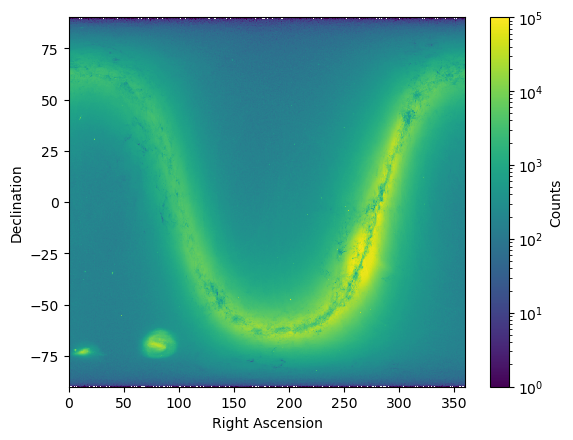

In [7]:
plt.pcolormesh(x, y, z, norm=matplotlib.colors.LogNorm(1,1.e5), cmap='viridis')
plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.colorbar(label='Counts')
plt.savefig("gaia_hist.png")

### Cluster Spin-down

In [8]:
spark.stop()